# モデルの定義
- PLS

  多重共線性。寄与率見れる。
  相関関係がある複数の予測子変数が含まれているデータに用いる

- LASSO

  残差二乗和に罰則項を設け、過剰適合を防ぐ
  
- SVR

  説明変数を非線形変換した後の「特徴量空間」の中で誤差を少なくする。 => カーネル関数を用いて類似度を測定している。
  精度が高い
  
- GPR
  
- RF

  ブースティングを使ったアンサンブル決定木、精度が高い、結果がわかりやすい。
  
- GBDT

  勾配ブースティング
  
- XGB

外側3-fold-CV、内側に5-fold-CVを用いたダブルクロスバリデーションでモデルを選定した。

In [1]:
each_method_dataset = {'method1': ['X','y']}

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold,GridSearchCV,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

In [3]:
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)


In [4]:
def calc_scores(X,y,model):
    cv  = KFold(5, shuffle=True, random_state=0)
    score_funcs = {
        'r2': make_scorer(r2_scorer),
        'rmse': make_scorer(rmse_scorer),
        'mae': make_scorer(mae_scorer),
    }

    scores = cross_validate(model, X, y, cv=cv, scoring=score_funcs)
    display(pd.DataFrame(scores))

In [5]:
def predict_easy(X,y, param_grid, estimator):
    inner_cv = KFold(3, shuffle=True, random_state=0)
    outer_cv = KFold(5, shuffle=True, random_state=0)

    # cross-validation
    gsv_dcv = GridSearchCV(estimator, param_grid, cv=inner_cv)

    score_funcs = {
            'r2': make_scorer(r2_scorer),
            'rmse': make_scorer(rmse_scorer),
            'mae': make_scorer(mae_scorer),
        }

    scores = cross_validate(gsv_dcv, X, y, cv=outer_cv, scoring=score_funcs)
    display(pd.DataFrame(scores))
    return scores

In [6]:
def predict_score(X,y,param_grid, estimator):
    df = pd.concat([X,y],axis=1)
    # グリッドサーチのスコア、グリッドサーチの最適モデル、yの予測値、yの観測値、最適モデルでのR2,RMSE,MAEをそれぞれ定義する
    results = {
        'gs_scores': [],
        'best_estimators': [],
        'df_y_train_preds': pd.DataFrame(),
        'df_y_train_reals': pd.DataFrame(),
        'df_y_preds': pd.DataFrame(),
        'df_y_reals': pd.DataFrame(),
        'r2_train': [],
        'r2': [],
        'rmse': [],
        'mae': [],
    }

    # 外側と内側のCVの分割数を定義する
    outer_cv = 5
    inner_cv = 3

    # 外側のクロスバリデーションをKFoldで設定する（5分割する）
    kfold = KFold(n_splits = outer_cv)
    for train, test in kfold.split(df):
        X_train = df.iloc[train,:-1]
        y_train = df.iloc[train, -1]
        X_test = df.iloc[test,:-1]
        y_test = df.iloc[test, -1]

        # 内側のクロスバリデーションをGridSearchCVで設定する（4分割する）
        gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="r2", cv=inner_cv, return_train_score=True)
        gs.fit(X=X_train, y=y_train)
        gs_score = gs.best_score_
        results['gs_scores'].append(gs_score)
        best_estimator = gs.best_estimator_
        print(best_estimator,'score: ',gs_score)
        results['best_estimators'].append(best_estimator)
        y_train_pred = best_estimator.predict(X_train)
        results['df_y_train_preds'] = pd.concat([results['df_y_train_preds'], pd.DataFrame(y_train_pred)])
        results['df_y_train_reals'] = pd.concat([results['df_y_train_reals'], y_train])
        y_pred = best_estimator.predict(X_test)
        results['df_y_preds'] = pd.concat([results['df_y_preds'], pd.DataFrame(y_pred)])
        results['df_y_reals'] = pd.concat([results['df_y_reals'], y_test])
        # 構築したモデルのスコア
        results['r2_train'].append(r2_scorer(y_train, y_train_pred))
        r2 = r2_scorer(y_test,y_pred)
        print('test r2 score: ', r2)
        results['r2'].append(r2)
        results['rmse'].append(rmse_scorer(y_test, y_pred))
        results['mae'].append(mae_scorer(y_test,y_pred))
    return results

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "DejaVu Serif"

def yyplot(y_obs, y_pred, title):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('Real Y', fontsize=24)
    plt.ylabel('Predicted Y', fontsize=24)
    plt.title(title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

def plot_result(results, method, estimator):
    title = f'{method} estimator {estimator}'
    yyplot(results['df_y_train_reals'].values, results['df_y_train_preds'].values, 'train '+title)
    yyplot(results['df_y_reals'].values, results['df_y_preds'].values, title)
    columns=['r2_train', 'r2', 'rmse', 'mae']
    
    result = pd.DataFrame([results['r2_train'], results['r2'], results['rmse'], results['mae']]).T.set_axis(columns, axis='columns').mean()
    result.name = method
    return result

In [8]:
# svr
from sklearn import svm
def exec_svm(each_method_dataset):
    # ハイパーパラメータ: https://qiita.com/oki_kosuke/items/a09878562a0c87b217c2
    C_range = list(2 ** np.arange(-5, 11, dtype=float))
    epsilon_range = list(2 ** np.arange(-10, 1, dtype=float))
    gamma_range = list(2 ** np.arange(-20, 11, dtype=float))
    param_grid = {"C":C_range, "epsilon":epsilon_range, "gamma":gamma_range}
    # param_grid = {"C": [1,10]}

    svr = svm.SVR(kernel="rbf")

    scores = []
    for method, xy in each_method_dataset.items():
        print('method:',method)
        results = predict_score(* xy, param_grid, svr)
        score = plot_result(results, method, 'svr')
        scores.append(score)
    display(pd.concat(scores,axis=1))

In [10]:
# rf
from sklearn.ensemble import RandomForestRegressor
def exec_rf(each_method_dataset):
    # ハイパーパラメータ:https://tatsu-mk2.hatenablog.jp/entry/2019/05/04/185733
    rf = RandomForestRegressor()
    param_grid = {'n_estimators':[10, 100, 200, 300], 'max_depth':[5, 10, 50, None], 'max_features': ["sqrt", "log2", None]}
    scores = []
    models = []
    for method, xy in each_method_dataset.items():
         print('method:',method)
        results = predict_score(* xy, param_grid, rf)
        score = plot_result(results, method, 'rf')
        scores.append(score)
        models.append(results['best_estimators'])
    display(pd.concat(scores,axis=1))
    return models

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

In [11]:
# PLS
from sklearn.cross_decomposition import PLSRegression
def exec_pls(each_method_dataset):
    pls = PLSRegression()
    param_grid = {'n_components': [2, 3, 4, 5, 6], 'scale':[True, False], 'max_iter': [5000]}

    scores = []
    models = []
    for method, xy in each_method_dataset.items():
        print('method:',method)
        results = predict_score(* xy, param_grid, pls)
        models.append(results['best_estimators'])
        score = plot_result(results, method, 'pls')
        scores.append(score)
    display(pd.concat(scores,axis=1))
    return models

In [12]:
# LASSO
from sklearn.linear_model import Lasso

def exec_lasso(each_method_dataset):
    # ハイパーパラメータ:https://qiita.com/damyarou/items/10a43358a96ed5d13832
    lasso = Lasso()
    # param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]}
    param_grid = {'alpha':[0.0625], 'max_iter': [50000]}

    scores = []
    models = []
    for method, xy in each_method_dataset.items():
        print('method:',method)
        results = predict_score(* xy, param_grid, lasso)
        models.append(results['best_estimators'])
        score = plot_result(results, method, 'lasso')
        scores.append(score)
    display(pd.concat(scores,axis=1))
    return models

In [13]:
# 勾配ブースティング
from sklearn.ensemble import GradientBoostingRegressor

def exec_gbr(each_method_dataset):
    # ハイパーパラメータ:https://qiita.com/maskot1977/items/c648e398b3b86cb68ae5
    gbr = GradientBoostingRegressor()
    param_grid = [{
        'learning_rate':[0.1,0.2],
        'n_estimators':[20,100],
        'max_depth':[3,5]
    }]

    scores = []
    for method, xy in each_method_dataset.items():
        print(method)
        results = predict_score(* xy, param_grid, gbr)
        score = plot_result(results, method, 'gbr')
        scores.append(score)
    display(pd.concat(scores,axis=1))

In [14]:
def exec_pls_easy(each_method_dataset):
    pls = PLSRegression()
    param_grid = {'n_components': [2, 3, 4, 5, 6], 'scale':[True, False], 'max_iter': [1000]}

    scores = []
    for method, xy in each_method_dataset.items():
        print(method)
        results = predict_easy(* xy, param_grid, pls)
        print(results)
        # score = plot_result(results, method, 'pls')
        # scores.append(score)
    # display(pd.concat(scores,axis=1))

- GPR
- GBDT
- XGB

# Excec
method1をそれぞれについて


In [100]:
method = 'method1'
df_methodx_avalon = pd.read_csv(f'./data/{method}/avalon.csv', index_col=0)
df_methodx_maccs = pd.read_csv(f'./data/{method}/maccs.csv', index_col=0)
df_methodx_minhash = pd.read_csv(f'./data/{method}/minhash.csv', index_col=0)
df_methodx_mordred_2d = pd.read_csv(f'./data/{method}/mordred_2d.csv', index_col=0)
df_methodx_mordred_3d = pd.read_csv(f'./data/{method}/mordred_3d.csv', index_col=0)
df_methodx_morgan_feature = pd.read_csv(f'./data/{method}/morgan_feature.csv', index_col=0)
df_methodx_morgan = pd.read_csv(f'./data/{method}/morgan.csv', index_col=0)
df_methodx_rdkit = pd.read_csv(f'./data/{method}/rdkit.csv', index_col=0)

methodx = [
    df_methodx_avalon,
    df_methodx_maccs,
    df_methodx_minhash,
    # df_methodx_mordred_2d,
    # df_methodx_mordred_3d,
    df_methodx_morgan_feature,
    df_methodx_morgan,
    df_methodx_rdkit
]
methodx_name = [
    f"df_{method}_avalon",
    f"df_{method}_maccs",
    f"df_{method}_minhash",
    # f"df_{method}_mordred_2d",
    # f"df_{method}_mordred_3d",
    f"df_{method}_morgan_feature",
    f"df_{method}_morgan",
    f"df_{method}_rdkit"
]

method: df_method2_avalon
Lasso(alpha=0.0625, max_iter=50000) score:  -6.876544974507277
test r2 score:  0.686052338989878
Lasso(alpha=0.0625, max_iter=50000) score:  -6.9239343781914044
test r2 score:  -0.7853384299090362
Lasso(alpha=0.0625, max_iter=50000) score:  -3.7248780902506975
test r2 score:  0.5243785802977612
Lasso(alpha=0.0625, max_iter=50000) score:  -13.205140624979412
test r2 score:  -1.7111003413699284
Lasso(alpha=0.0625, max_iter=50000) score:  -11.138078967172454
test r2 score:  -195.24864787355722


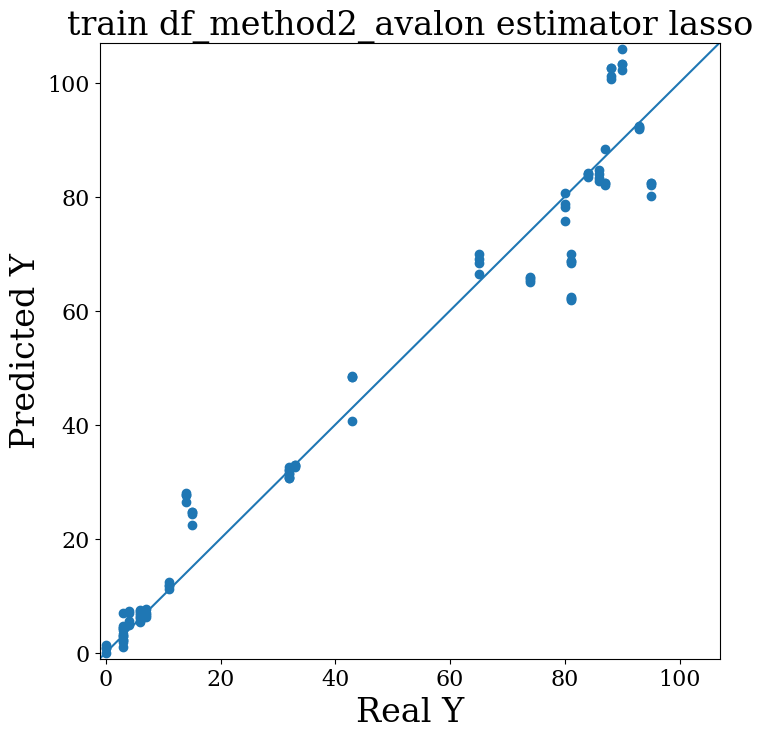

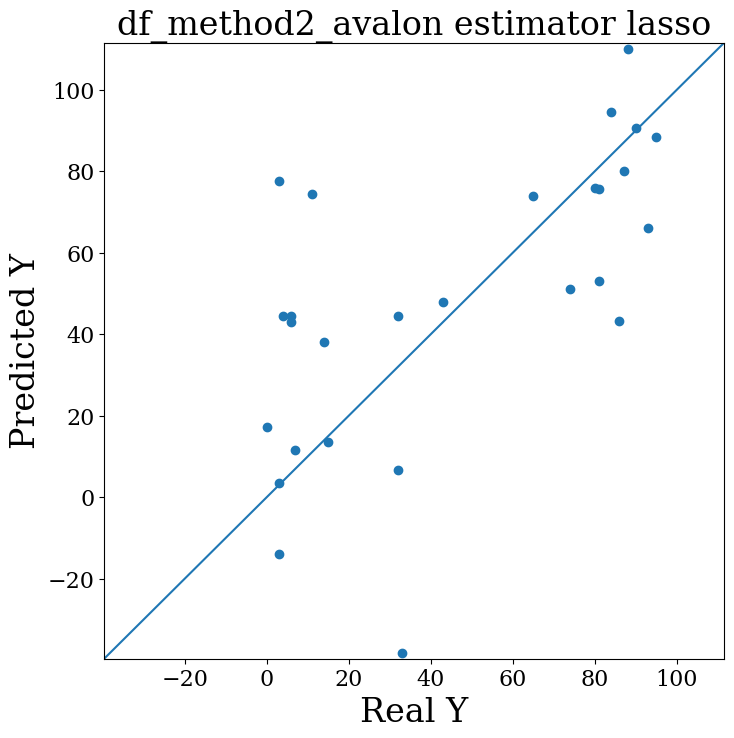

,df_method2_avalon
r2_train,0.957221
r2,-39.306931
rmse,29.595628
mae,23.262367


method: df_method2_maccs
Lasso(alpha=0.0625, max_iter=50000) score:  -10.944288376139307
test r2 score:  0.7202631544624132
Lasso(alpha=0.0625, max_iter=50000) score:  -7.857828573819986
test r2 score:  0.7129712151913377
Lasso(alpha=0.0625, max_iter=50000) score:  -2.706896892118401
test r2 score:  -0.3388537737335946
Lasso(alpha=0.0625, max_iter=50000) score:  -23.894380392836368
test r2 score:  -0.5484096795298599
Lasso(alpha=0.0625, max_iter=50000) score:  -8.570876270758566
test r2 score:  -755.9785085315247


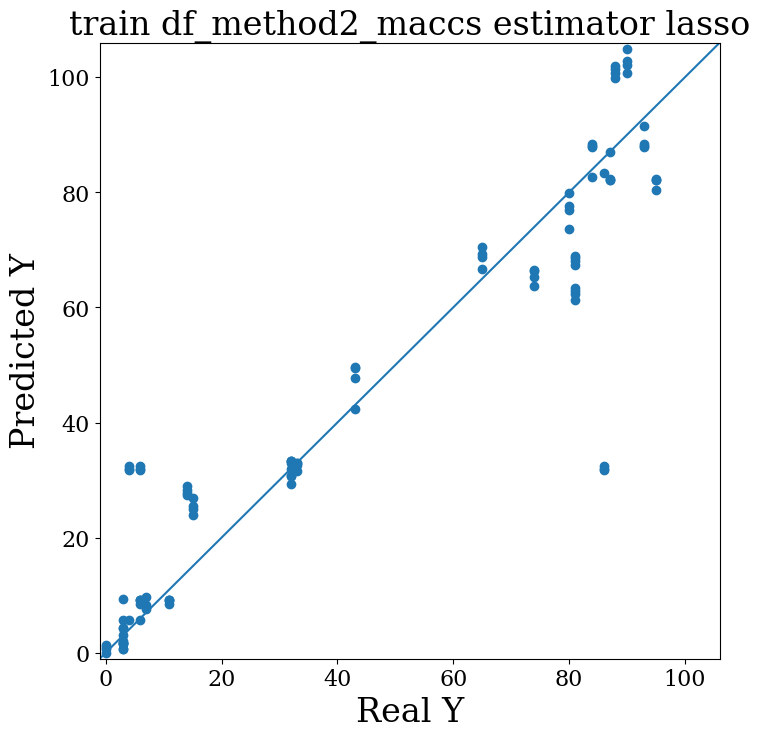

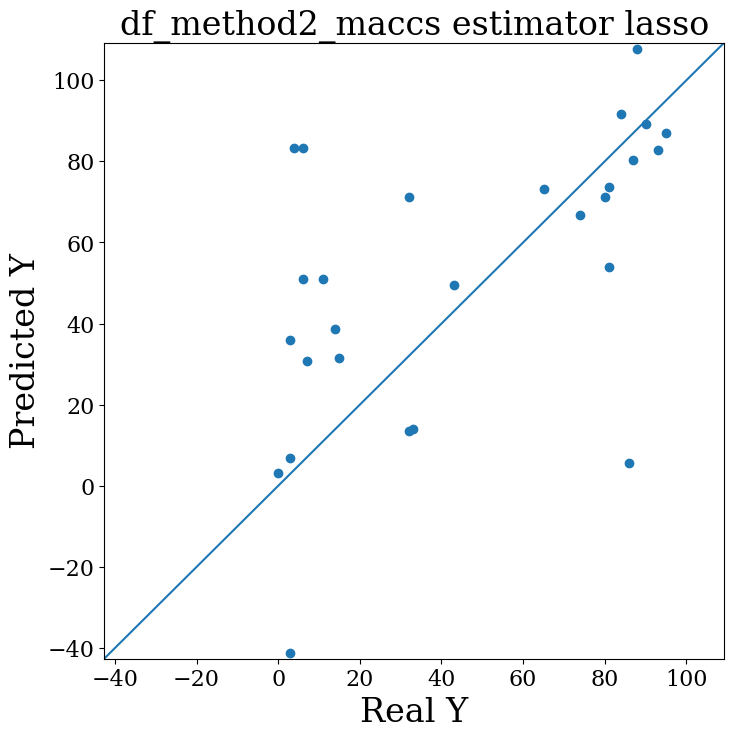

,df_method2_maccs
r2_train,0.862480
r2,-151.086508
rmse,31.526982
mae,25.601660


method: df_method2_minhash
Lasso(alpha=0.0625, max_iter=50000) score:  -6.4675498621017296
test r2 score:  0.33168270556389823
Lasso(alpha=0.0625, max_iter=50000) score:  -12.228609648726012
test r2 score:  0.4939781735144595
Lasso(alpha=0.0625, max_iter=50000) score:  -4.878988185046238
test r2 score:  -2.2547671503899323
Lasso(alpha=0.0625, max_iter=50000) score:  -13.047700968755763
test r2 score:  -4.328678764585931
Lasso(alpha=0.0625, max_iter=50000) score:  -8.147996985744278
test r2 score:  -272.18191474347896


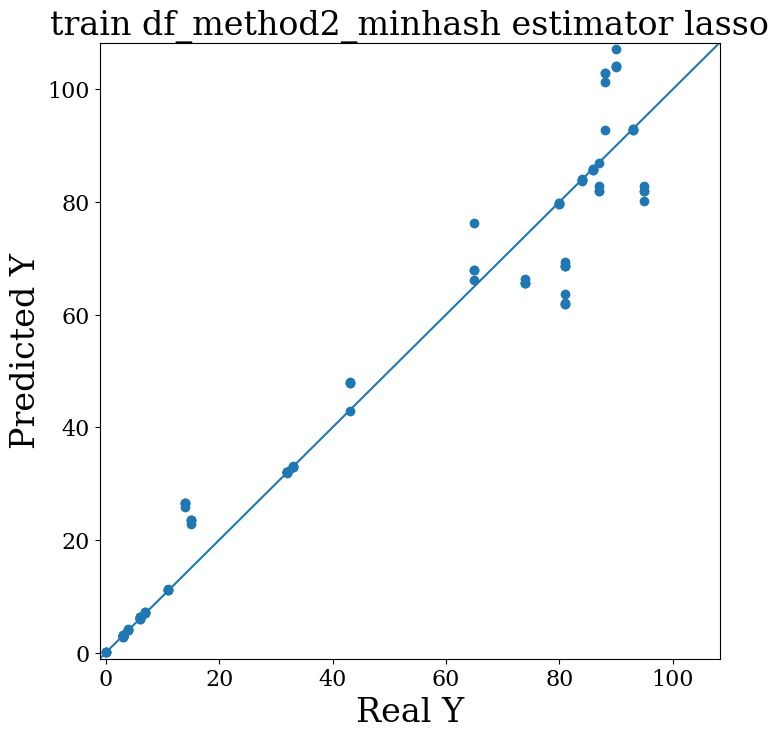

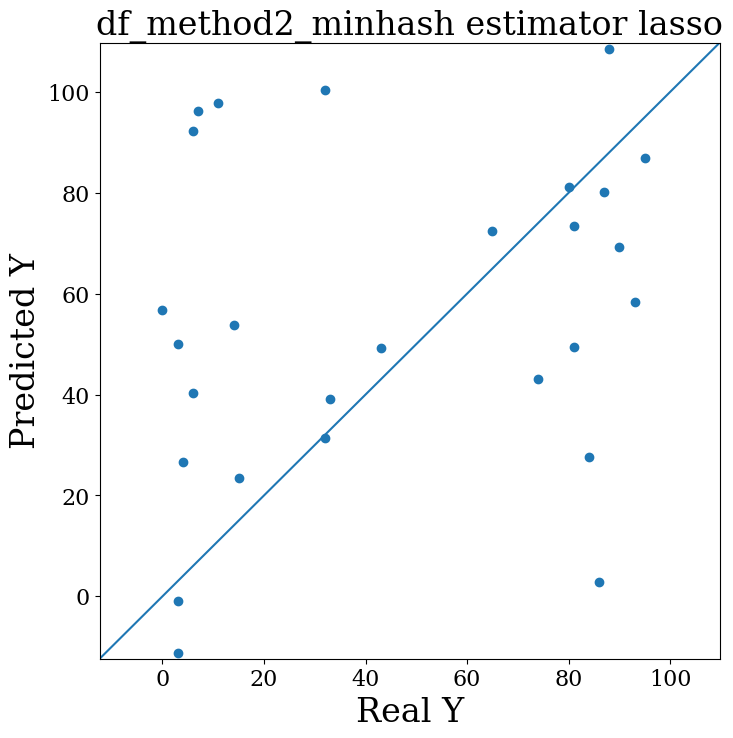

,df_method2_minhash
r2_train,0.958877
r2,-55.587940
rmse,40.386798
mae,33.730583


method: df_method2_morgan_feature
Lasso(alpha=0.0625, max_iter=50000) score:  -8.50860893620224
test r2 score:  -2.8184982859277996
Lasso(alpha=0.0625, max_iter=50000) score:  -9.99989662207143
test r2 score:  0.1413999749740048
Lasso(alpha=0.0625, max_iter=50000) score:  -5.300664418935704
test r2 score:  -1.1763810567262407
Lasso(alpha=0.0625, max_iter=50000) score:  -23.74906385160267
test r2 score:  -2.0628983744151195
Lasso(alpha=0.0625, max_iter=50000) score:  -14.478016286986014
test r2 score:  -222.13879380180273


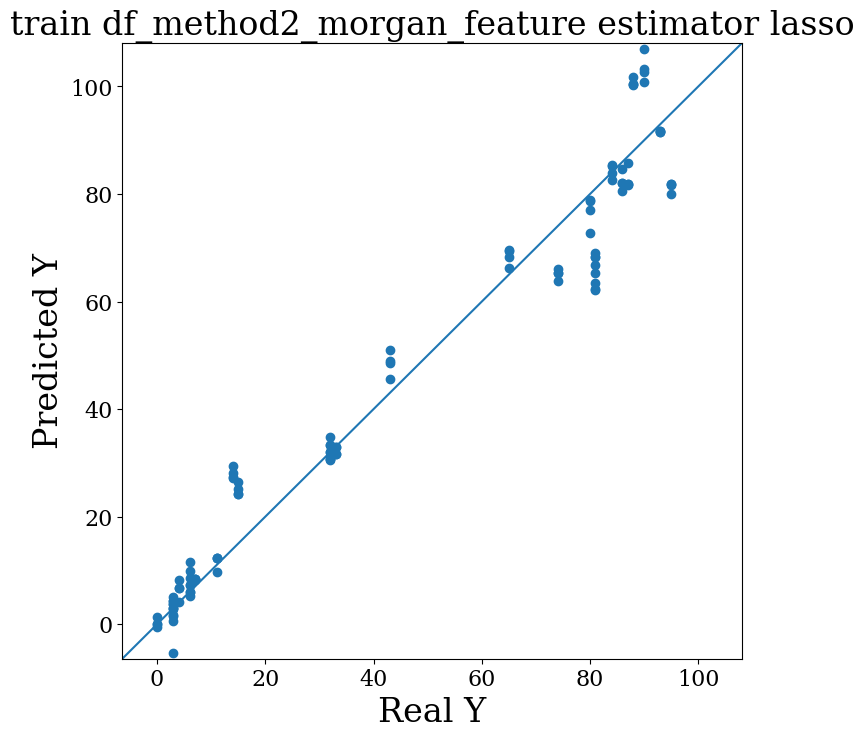

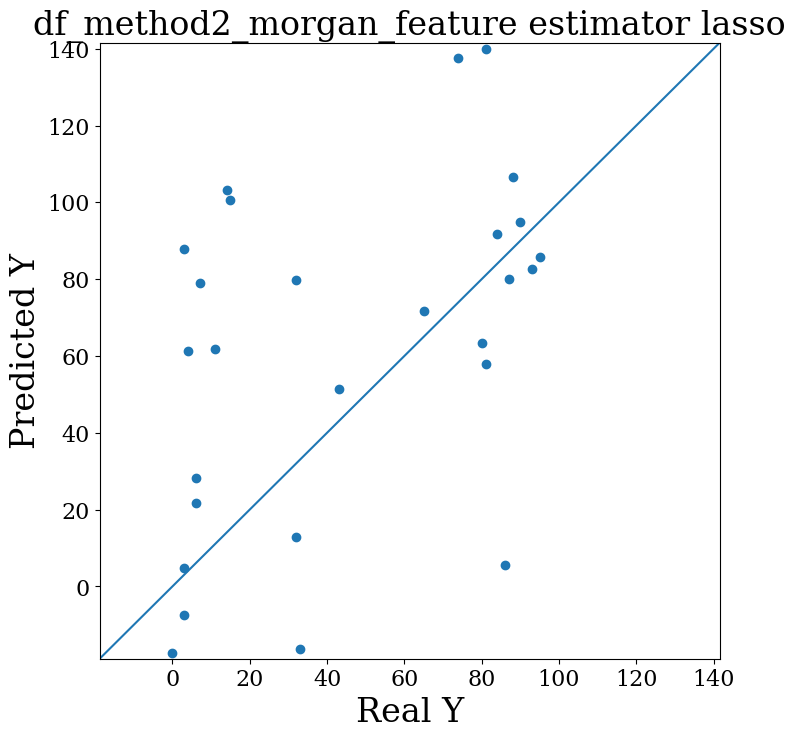

,df_method2_morgan_feature
r2_train,0.955136
r2,-45.611034
rmse,42.686731
mae,34.710671


method: df_method2_morgan
Lasso(alpha=0.0625, max_iter=50000) score:  -9.864639925774334
test r2 score:  0.4810995264023876
Lasso(alpha=0.0625, max_iter=50000) score:  -13.018056135731705
test r2 score:  -1.437634141350189
Lasso(alpha=0.0625, max_iter=50000) score:  -5.8688143755254005
test r2 score:  0.4368473872551194
Lasso(alpha=0.0625, max_iter=50000) score:  -24.58573990437968
test r2 score:  -2.4266891892599154
Lasso(alpha=0.0625, max_iter=50000) score:  -11.938613248126368
test r2 score:  -24.883911599442456


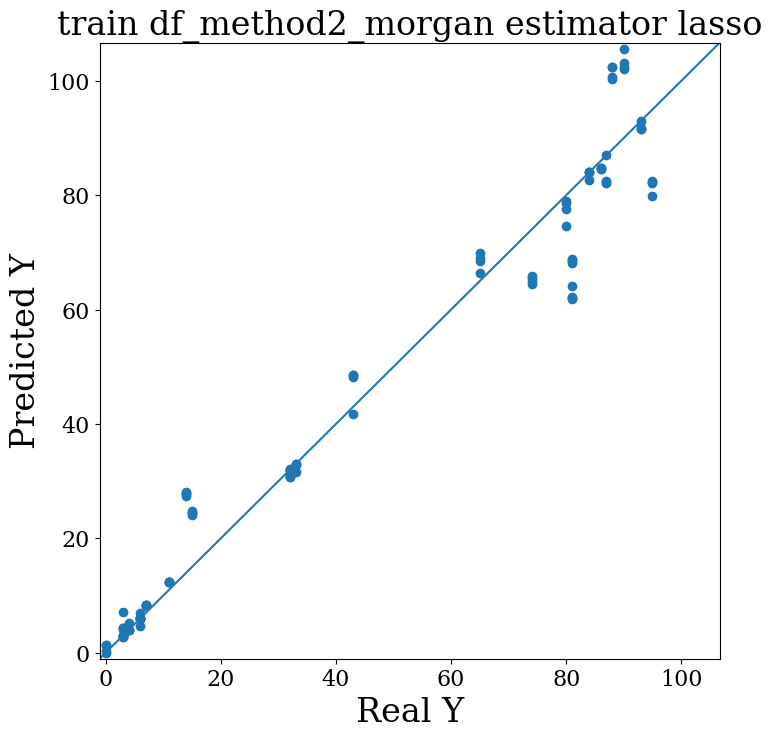

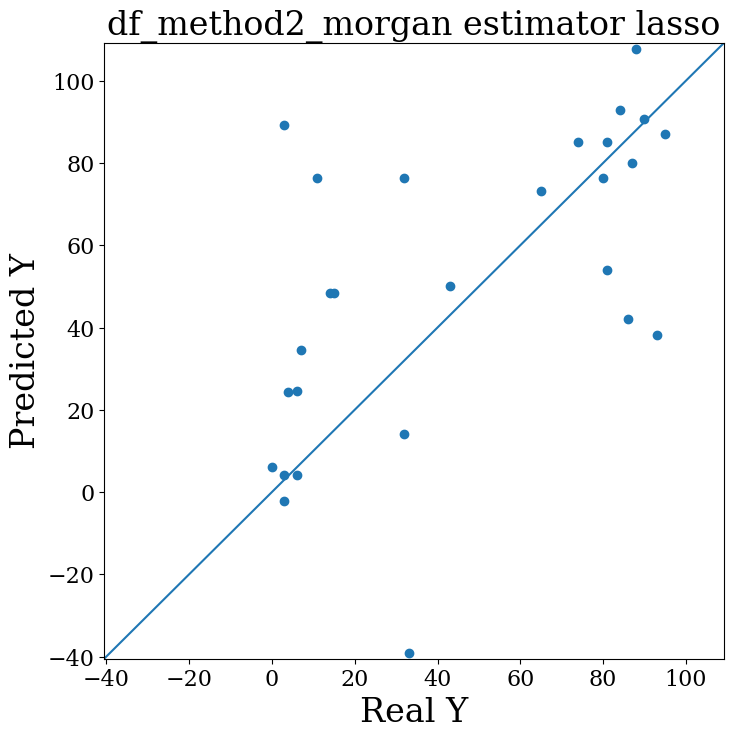

,df_method2_morgan
r2_train,0.957299
r2,-5.566058
rmse,29.838680
mae,23.708818


method: df_method2_rdkit
Lasso(alpha=0.0625, max_iter=50000) score:  -5.376607604250324
test r2 score:  0.7063161365042536
Lasso(alpha=0.0625, max_iter=50000) score:  -5.732991383023163
test r2 score:  -1.7040273769765624
Lasso(alpha=0.0625, max_iter=50000) score:  -9.17020650380942
test r2 score:  -0.8880077157318784
Lasso(alpha=0.0625, max_iter=50000) score:  -17.522074945179615
test r2 score:  -2.3810310537643873
Lasso(alpha=0.0625, max_iter=50000) score:  -9.61890263966779
test r2 score:  -394.8867497436339


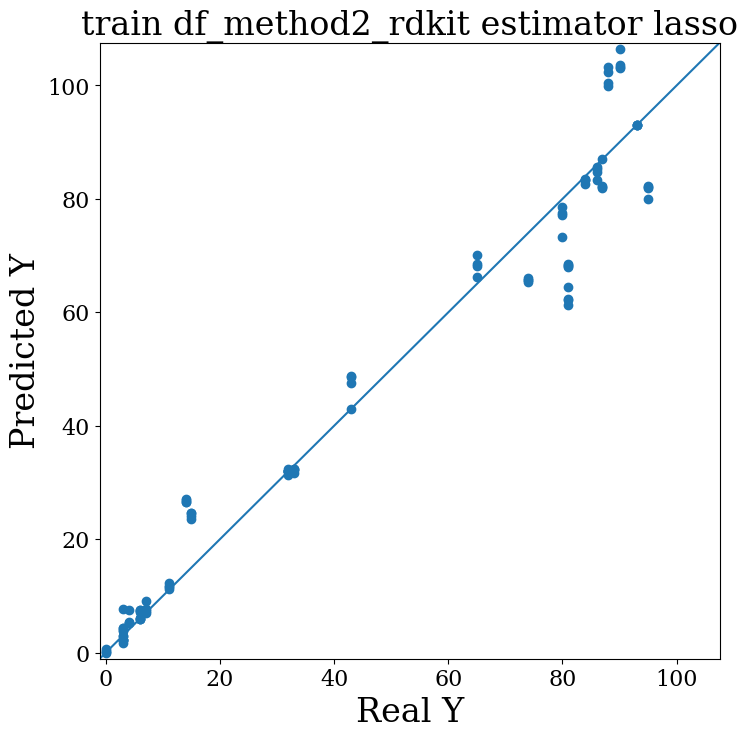

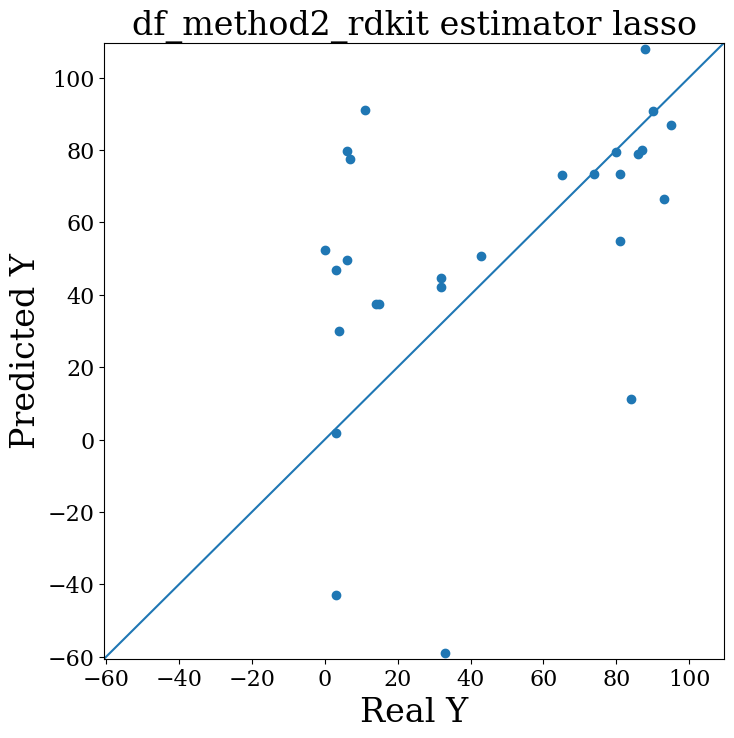

,df_method2_rdkit
r2_train,0.957324
r2,-79.830700
rmse,38.942035
mae,30.013888


{'df_method2_avalon': [[Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000)]],
 'df_method2_maccs': [[Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000)]],
 'df_method2_minhash': [[Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000)]],
 'df_method2_morgan_feature': [[Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000)]],
 'df_method2_morgan': [[Lasso(alpha=0.0625, max_iter=50000),
   Lasso(alpha=0.0625, max_iter=50000),

In [98]:
models = {}
for i in range(len(methodx)):
    X = methodx[i].drop(columns=['yield'])
    y = methodx[i]['yield']
    models[methodx_name[i]] = exec_lasso({methodx_name[i]:[X,y]})
models

In [76]:
for i in range(len(methodx)):
    X = methodx[i].drop(columns=['yield'])
    y = methodx[i]['yield']
    exec_rf({methodx_name[i]:[X,y]})

df_method2_avalon


KeyboardInterrupt: 

# Lasso

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def predictLasso(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    scaler = StandardScaler()
    clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1),max_iter=50000, cv=5)

    print(clf.alpha_)
    scaler.fit(X_train)
    clf.fit(scaler.transform(X_train), y_train)

    y_pred = clf.predict(scaler.transform(X_test))
    print('r2_train',clf.score(X_train,y_train))
    print('r2',clf.score(X_test,y_test))
    print('r2_check', r2_scorer(y_test,y_pred))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    print('rmse', rmse)
    print("mse",mse)
    return [y_pred,y_test]
    

In [135]:
for i in range(len(methodx)):
    print(methodx_name[i])
    X = methodx[i].drop(columns=['yield'])
    y = methodx[i]['yield']
    [y_pred,y_test] = predictLasso(X,y)
    yyplot(y_test.values,y_pred, f'{methodx_name[i]}_lasso')
    

df_method1_avalon


AttributeError: 'LassoCV' object has no attribute 'alpha_'

# 変数の選択

In [139]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

def selectVariants(X_train,y_train):
    scaler = StandardScaler()
    scaler.fit(X_train)

    sel_ = SelectFromModel(Lasso(alpha=0.0625, max_iter=50000))
    sel_.fit(scaler.transform(X_train), y_train)

    print(len(sel_.get_support()))
    print(sel_.get_support())

In [140]:
for i in range(len(methodx)):
    print(methodx_name[i])
    X = methodx[i].drop(columns=['yield'])
    y = methodx[i]['yield']
    selectVariants(X,y)

df_method1_avalon


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().